In [7]:
import torch
import numpy as np
import cv2
from facenet_pytorch import MTCNN, InceptionResnetV1
import joblib
from IPython.display import display


In [8]:
MODEL_PATH = "Models/face_recognition2.pkl"
IMAGE_PATH = "test_files/2.png"

In [9]:
def recognize_faces(input_img=IMAGE_PATH,MODEL_PATH=MODEL_PATH):
    # Load face detection and embedding models
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mtcnn = MTCNN(image_size=160, margin=20, device=device)
    resnet = InceptionResnetV1(pretrained="vggface2").eval().to(device)
    
    # Load trained classifier
    data = joblib.load(MODEL_PATH)
    clf = data["classifier"]
    encoder = data["encoder"]

    # Load test image
    try:
        img = cv2.imread(input_img)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error: {e}")
        
    
    # Detect faces
    boxes, _ = mtcnn.detect(img_rgb)

    if boxes is None:
        print(" No face detected!")
    else:
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)

            # Crop and preprocess face
            face = img_rgb[y1:y2, x1:x2]  # Crop face
            face = cv2.resize(face, (160, 160))  # Resize for FaceNet
            face = torch.tensor(face).permute(2, 0, 1).float().unsqueeze(0) / 255.0
            face = face.to(device)

            # Extract face embedding
            embedding = resnet(face).detach().cpu().numpy().flatten()

            # Predict identity
            probs = clf.predict_proba([embedding])[0]
            max_prob = max(probs)
            predicted_label = encoder.inverse_transform([np.argmax(probs)])[0]

            # Draw bounding box and label
            label_text = predicted_label if max_prob > 0.6 else "Unknown"
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"{label_text} ({max_prob:.2f})", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        display(PIL.Image.fromarray(image))

        return None

            
    

In [10]:
IMAGE_PATH = "test_files/4.png"  # Change this to your test image

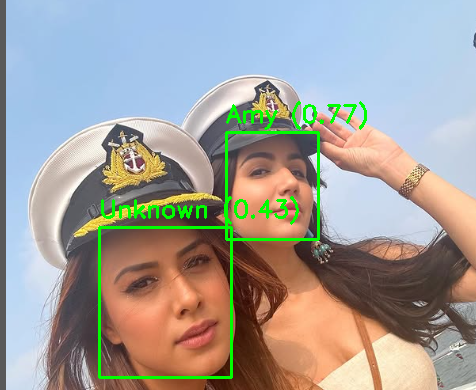

In [11]:
recognize_faces(input_img=IMAGE_PATH)